# Credit Card Fraud Detection using Deep Neural Network


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kagglehub
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)



In [2]:
# Load data
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
csv_file = os.path.join(path, 'creditcard.csv')
df = pd.read_csv(csv_file)

Using Colab cache for faster access to the 'creditcardfraud' dataset.


In [3]:
print("Dataset shape:", df.shape)
print("\nDataset preview:")
display(df.head())

print("\nClass distribution:")
print(df['Class'].value_counts())

Dataset shape: (284807, 31)

Dataset preview:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
num_features = df.shape[1] - 1  # minus the target column 'Class'
print("\nNumber of features (excluding target):", num_features)
print("Total columns including target:", df.shape[1])


Number of features (excluding target): 30
Total columns including target: 31


In [5]:
v_cols = [col for col in df.columns if col.startswith("V")]
print("\nV-feature columns:", v_cols)

print("\nDataset info:")
df.info()


V-feature columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 

In [6]:
# Data Cleaning
print("Data Cleaning Process:")
print(f"- Initial shape: {df.shape}")
print(f"- Missing values: {df.isnull().sum().sum()}")
print(f"- Duplicates: {df.duplicated().sum()}")

if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
if df.isnull().sum().sum() > 0:
    df = df.dropna()

print(f"- Final shape: {df.shape}")

Data Cleaning Process:
- Initial shape: (284807, 31)
- Missing values: 0
- Duplicates: 1081
- Final shape: (283726, 31)


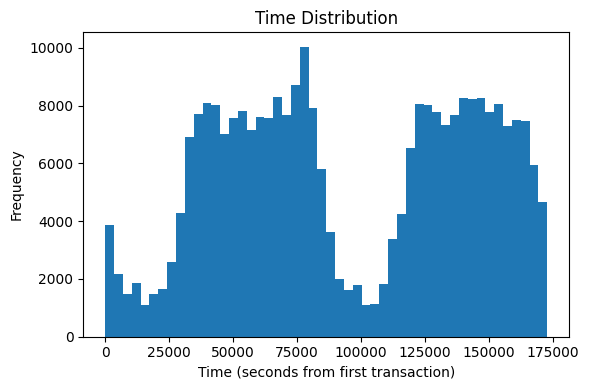

In [7]:
plt.figure(figsize=(6,4))
plt.hist(df['Time'], bins=50)
plt.title("Time Distribution")
plt.xlabel("Time (seconds from first transaction)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

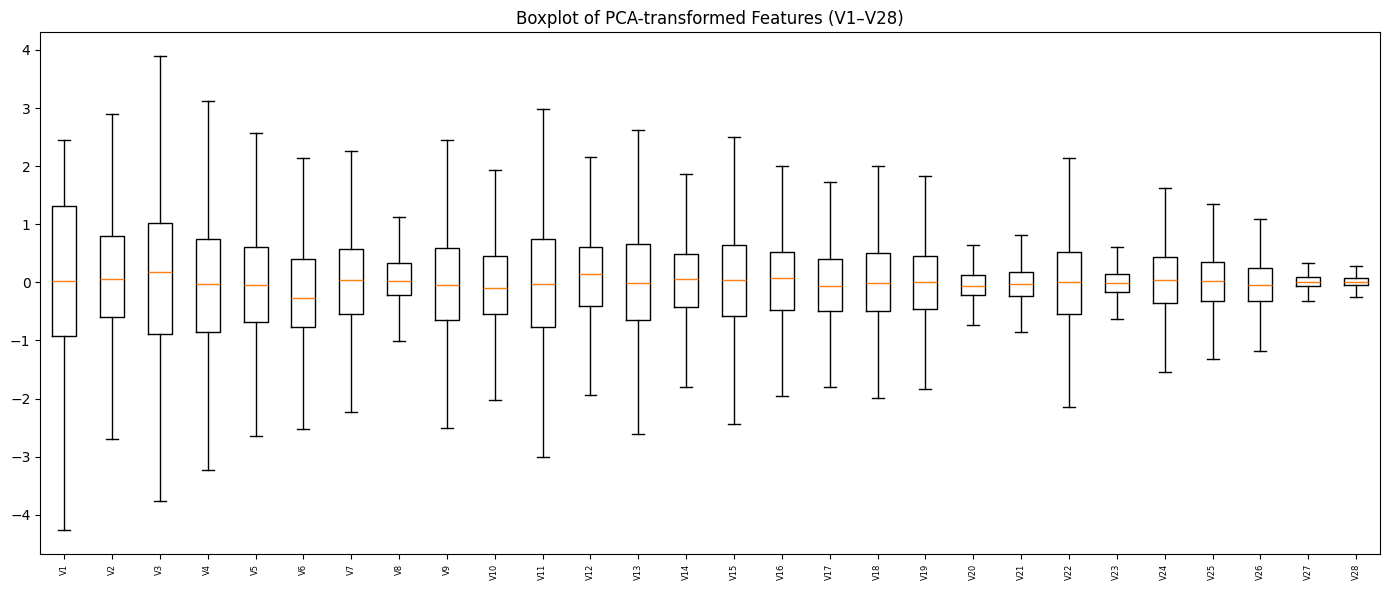

In [8]:
v_features = [col for col in df.columns if col.startswith("V")]

plt.figure(figsize=(14,6))
plt.boxplot(df[v_features].values, showfliers=False)
plt.title("Boxplot of PCA-transformed Features (V1–V28)")
plt.xticks(range(1, len(v_features)+1), v_features, rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

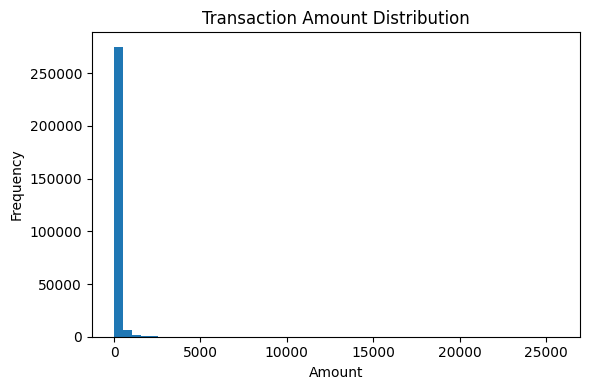

In [9]:
plt.figure(figsize=(6,4))
plt.hist(df['Amount'], bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

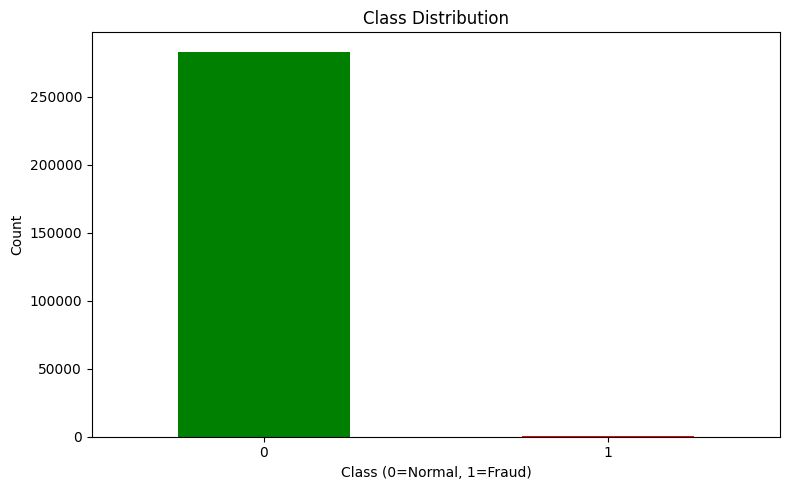

In [10]:
# Visualize class distribution
plt.figure(figsize=(8, 5))
df['Class'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()


In [11]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

In [12]:
# Pre-process: Scale 'Amount' and 'Time'
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))
X['Time'] = scaler.fit_transform(X['Time'].values.reshape(-1, 1))


In [13]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [14]:
# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


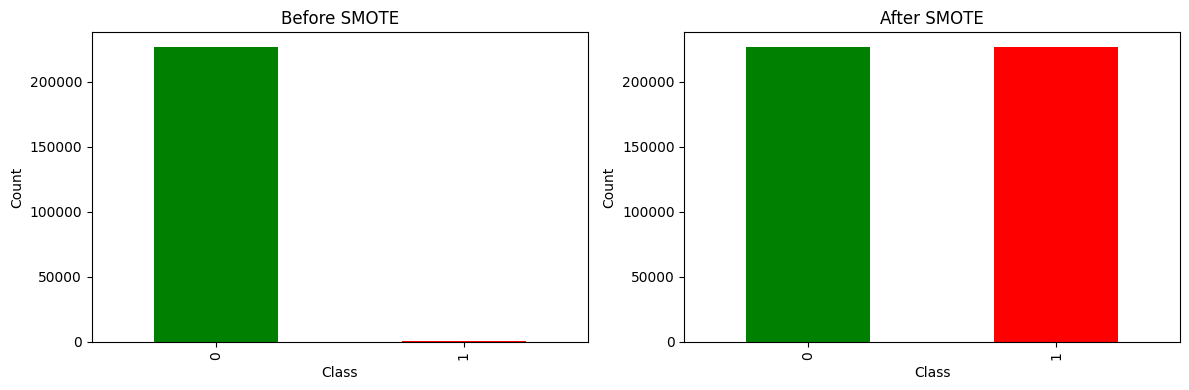

Class ratio BEFORE SMOTE:
Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64

Class ratio AFTER SMOTE:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [15]:
# Visualize class distribution after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
pd.Series(y_train_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.savefig('smote_comparison.png')
plt.show()

print("Class ratio BEFORE SMOTE:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nClass ratio AFTER SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


In [16]:
# Train multi-layer DNN
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

history = model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=256,
                    validation_split=0.2, verbose=1)

Epoch 1/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9262 - loss: 0.2090 - precision: 0.9200 - recall: 0.8786 - val_accuracy: 0.9992 - val_loss: 0.0167 - val_precision: 1.0000 - val_recall: 0.9992
Epoch 2/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9923 - loss: 0.0267 - precision: 0.9860 - recall: 0.9937 - val_accuracy: 0.9998 - val_loss: 0.0047 - val_precision: 1.0000 - val_recall: 0.9998
Epoch 3/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9966 - loss: 0.0141 - precision: 0.9927 - recall: 0.9981 - val_accuracy: 1.0000 - val_loss: 0.0023 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9976 - loss: 0.0104 - precision: 0.9947 - recall: 0.9989 - val_accuracy: 1.0000 - val_loss: 0.0015 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9981 - loss: 0.0086 - precision: 0.9961 - recall: 0.9990 - val_accuracy: 1.0000 - v

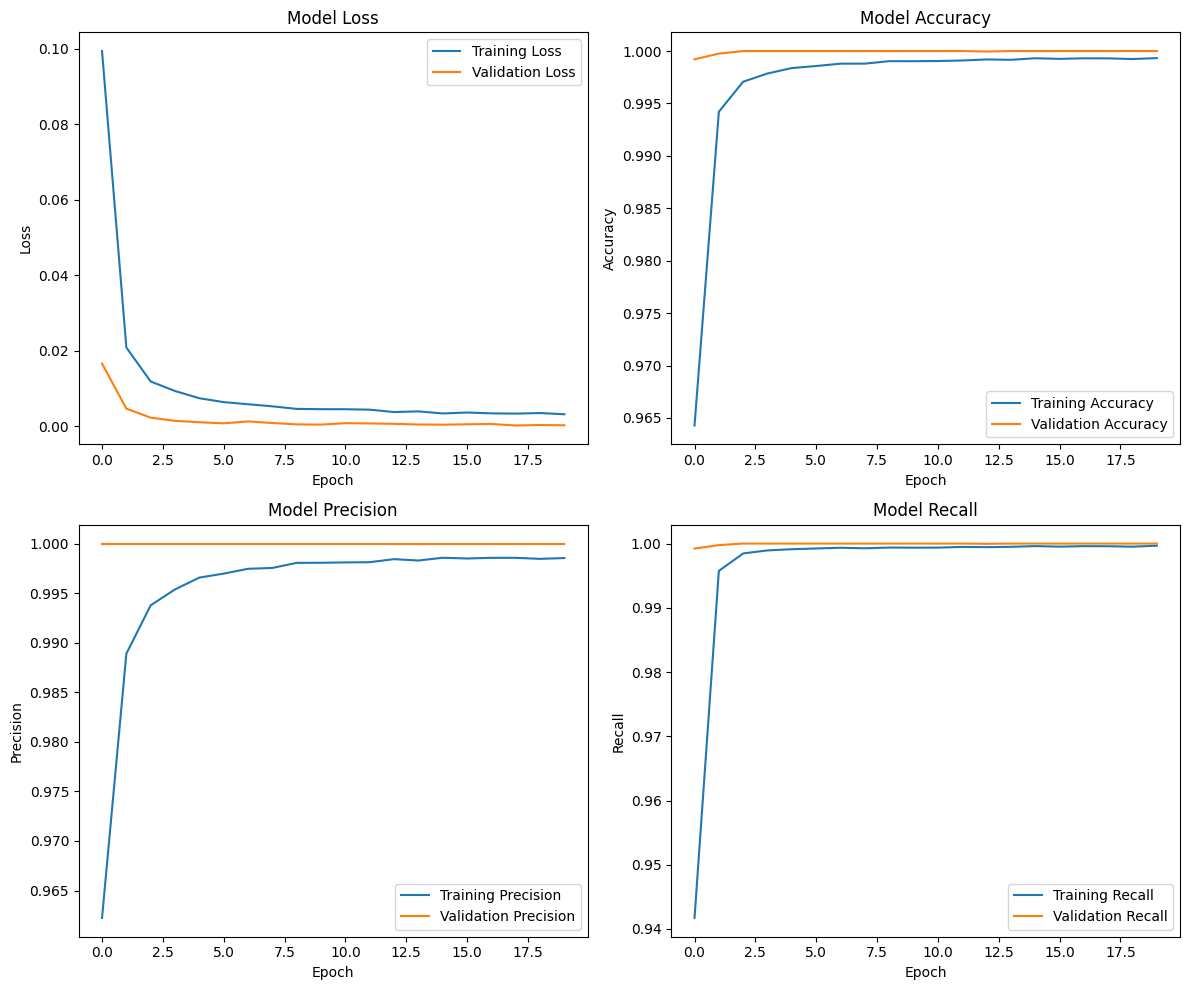

In [17]:

# Plot training history
keys = history.history.keys()

precision_key = [k for k in keys if 'precision' in k and not k.startswith('val')][0]
val_precision_key = [k for k in keys if 'precision' in k and k.startswith('val')][0]

recall_key = [k for k in keys if 'recall' in k and not k.startswith('val')][0]
val_recall_key = [k for k in keys if 'recall' in k and k.startswith('val')][0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 0].plot(history.history[precision_key], label='Training Precision')
axes[1, 0].plot(history.history[val_precision_key], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

axes[1, 1].plot(history.history[recall_key], label='Training Recall')
axes[1, 1].plot(history.history[val_recall_key], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()


In [18]:

# Evaluate using Precision, Recall, and AUPRC
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)


1774/1774 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [19]:
cm = confusion_matrix(y_test, y_pred)
classes = ['Legitimate (0)', 'Fraud (1)']

print("Confusion Matrix:")
print(f"\tPredicted {classes[0]}\tPredicted {classes[1]}")
print(f"Actual {classes[0]}\t{cm[0,0]}\t\t{cm[0,1]}")
print(f"Actual {classes[1]}\t{cm[1,0]}\t\t{cm[1,1]}")


Confusion Matrix:
	Predicted Legitimate (0)	Predicted Fraud (1)
Actual Legitimate (0)	56629		22
Actual Fraud (1)	23		72


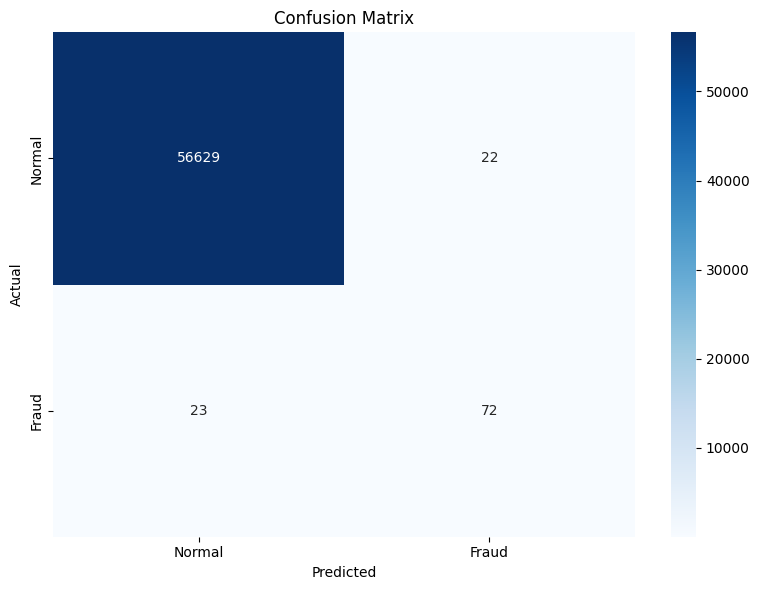

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [21]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.77      0.76      0.76        95

    accuracy                           1.00     56746
   macro avg       0.88      0.88      0.88     56746
weighted avg       1.00      1.00      1.00     56746



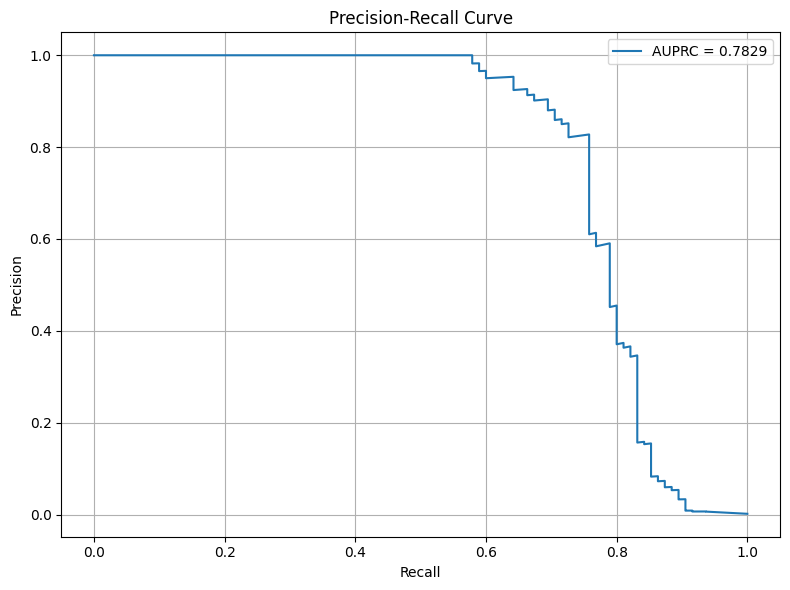

In [22]:

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('precision_recall_curve.png')
plt.show()

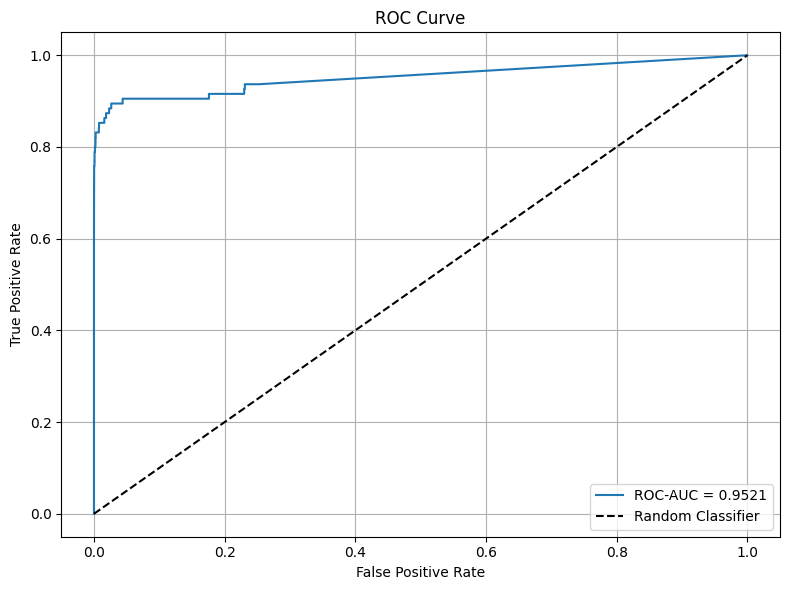

ROC-AUC: 0.9521


In [23]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()

print(f"ROC-AUC: {roc_auc:.4f}")

# Comparison Models

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve,
                             auc, precision_score, recall_score, f1_score)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X = df.drop('Class', axis=1)
y = df['Class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Fraud cases in test set: {sum(y_test)} ({sum(y_test)/len(y_test)*100:.4f}%)")


Training set size: 226980
Test set size: 56746
Fraud cases in test set: 95 (0.1674%)


## Logistic Regression

In [25]:
print("Training Logistic Regression...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculate PR-AUC
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
pr_auc_lr = auc(recall_lr, precision_lr)

print("\nLogistic Regression Results:")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"PR-AUC (Precision-Recall): {pr_auc_lr:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


Training Logistic Regression...

Logistic Regression Results:
Precision: 0.0564
Recall: 0.8737
F1-Score: 0.1059
ROC-AUC: 0.9657
PR-AUC (Precision-Recall): 0.7046

Confusion Matrix:
[[55262  1389]
 [   12    83]]


## XGBoost

In [26]:
print("Training XGBoost...")

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='aucpr'
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)

print("\nXGBoost Results:")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"PR-AUC (Precision-Recall): {pr_auc_xgb:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


Training XGBoost...

XGBoost Results:
Precision: 0.8152
Recall: 0.7895
F1-Score: 0.8021
ROC-AUC: 0.9650
PR-AUC (Precision-Recall): 0.8108

Confusion Matrix:
[[56634    17]
 [   20    75]]


## Compare results

In [27]:
# Scale the test data - NN needs scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Get predictions
y_pred_proba_nn = model.predict(X_test_scaled).flatten()
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

print(f"Prediction shape: {y_pred_nn.shape}")
print(f"Probability shape: {y_pred_proba_nn.shape}")

# Collect all model results

from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             precision_recall_curve, auc, classification_report)

models = {
    'Logistic Regression': {
        'predictions': y_pred_lr,
        'probabilities': y_pred_proba_lr,
        'cm': confusion_matrix(y_test, y_pred_lr)
    },
    'XGBoost': {
        'predictions': y_pred_xgb,
        'probabilities': y_pred_proba_xgb,
        'cm': confusion_matrix(y_test, y_pred_xgb)
    },
    'Neural Network': {
        'predictions': y_pred_nn,
        'probabilities': y_pred_proba_nn,
        'cm': confusion_matrix(y_test, y_pred_nn)
    }
}

# Calculate metrics for all models
metrics_data = []
for model_name, model_data in models.items():
    precision = precision_score(y_test, model_data['predictions'])
    recall = recall_score(y_test, model_data['predictions'])
    f1 = f1_score(y_test, model_data['predictions'])
    roc_auc = roc_auc_score(y_test, model_data['probabilities'])

    # Calculate PR-AUC
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, model_data['probabilities'])
    pr_auc = auc(rec_curve, prec_curve)

    # Get confusion matrix values
    tn, fp, fn, tp = model_data['cm'].ravel()

    metrics_data.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn,
        'True Negatives': tn
    })

df_metrics = pd.DataFrame(metrics_data)


print("Detailed Classification Reports")

for model_name, model_data in models.items():
    print(f"{model_name}")
    print(classification_report(y_test, model_data['predictions'],
                                target_names=['Not Fraud', 'Fraud']))
    print(f"Confusion Matrix:")
    print(model_data['cm'])










1774/1774 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Prediction shape: (56746,)
Probability shape: (56746,)
Detailed Classification Reports
Logistic Regression
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99     56651
       Fraud       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746

Confusion Matrix:
[[55262  1389]
 [   12    83]]
XGBoost
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56651
       Fraud       0.82      0.79      0.80        95

    accuracy                           1.00     56746
   macro avg       0.91      0.89      0.90     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
[[56634    17]
 [   20    75]]
Neural Network
              precision    recall  f1-score   support

   Not Fraud       1

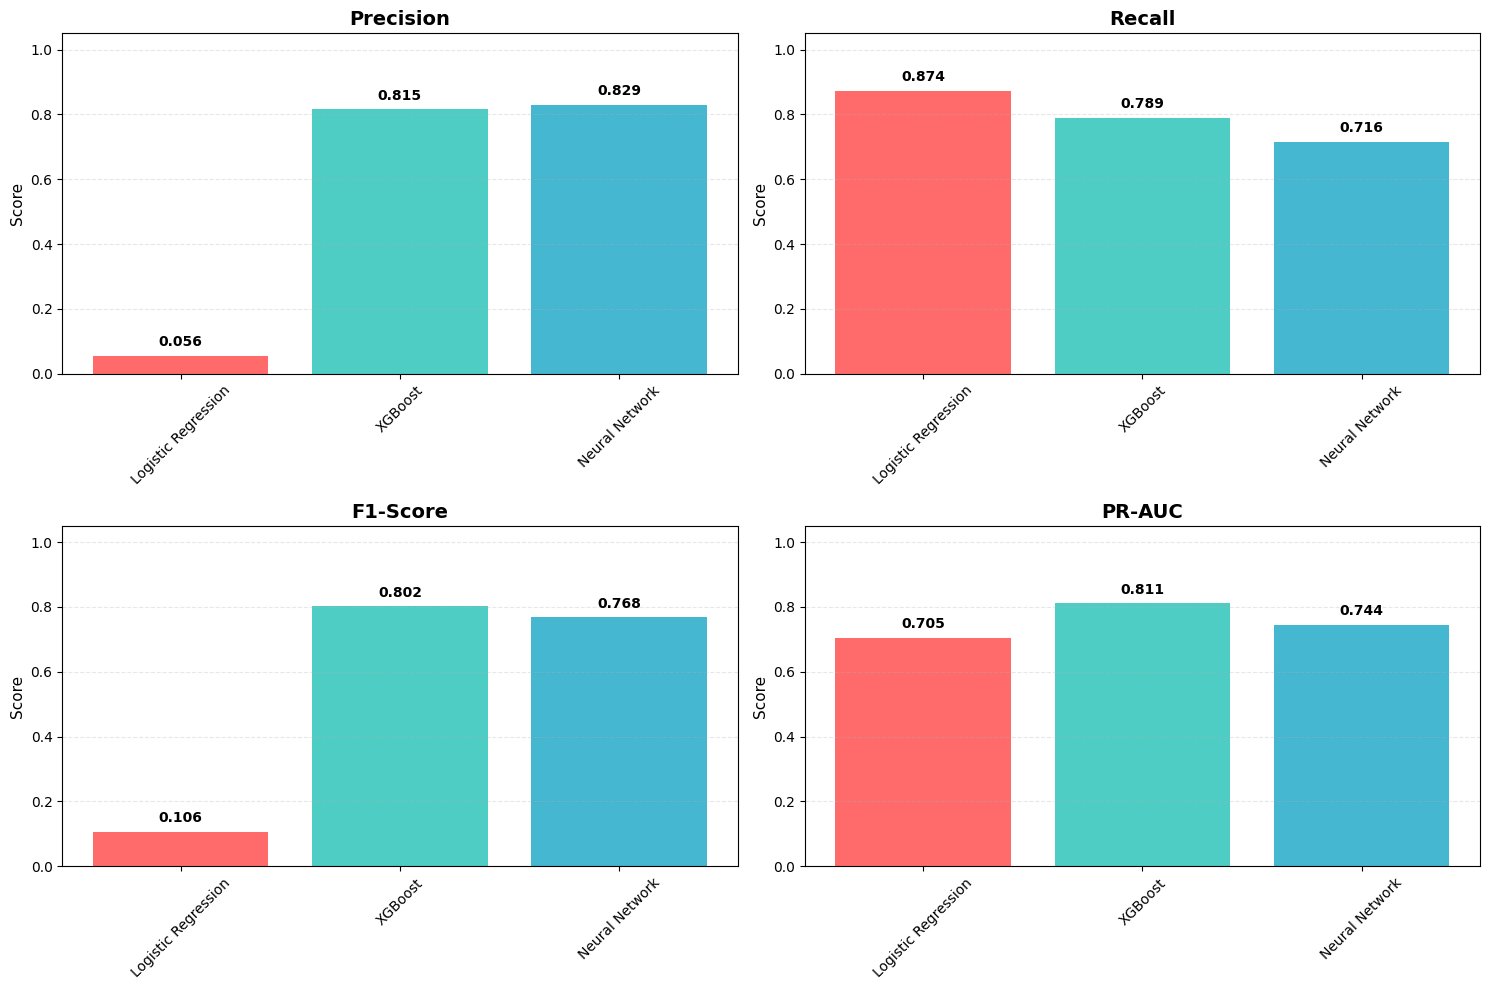

In [28]:
# Metrics bar chart

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'PR-AUC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2

    values = df_metrics[metric].values
    bars = axes[row, col].bar(df_metrics['Model'], values, color=colors)

    axes[row, col].set_title(metric, fontsize=14, fontweight='bold')
    axes[row, col].set_ylim([0, 1.05])
    axes[row, col].set_ylabel('Score', fontsize=11)
    axes[row, col].grid(axis='y', alpha=0.3, linestyle='--')

    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                           f'{height:.3f}',
                           ha='center', va='bottom', fontweight='bold')

    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

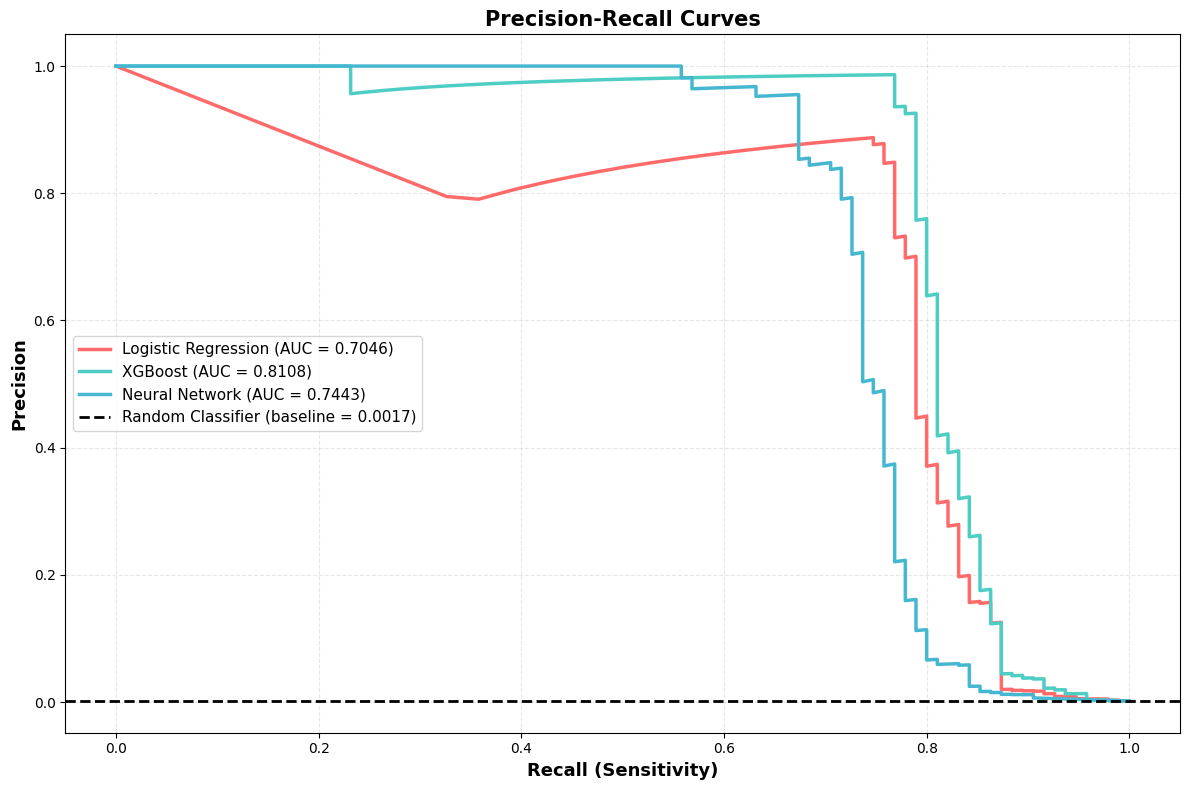

In [29]:
# Precision-recall curves

plt.figure(figsize=(12, 8))

colors_pr = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for idx, (model_name, model_data) in enumerate(models.items()):
    precision, recall, _ = precision_recall_curve(y_test, model_data['probabilities'])
    pr_auc_val = df_metrics[df_metrics['Model']==model_name]['PR-AUC'].values[0]

    plt.plot(recall, precision, linewidth=2.5, color=colors_pr[idx],
            label=f'{model_name} (AUC = {pr_auc_val:.4f})')

# Add baseline (random classifier)
fraud_rate = sum(y_test) / len(y_test)
plt.axhline(y=fraud_rate, color='k', linestyle='--', linewidth=2,
           label=f'Random Classifier (baseline = {fraud_rate:.4f})')

plt.xlabel('Recall (Sensitivity)', fontsize=13, fontweight='bold')
plt.ylabel('Precision', fontsize=13, fontweight='bold')
plt.title('Precision-Recall Curves',
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

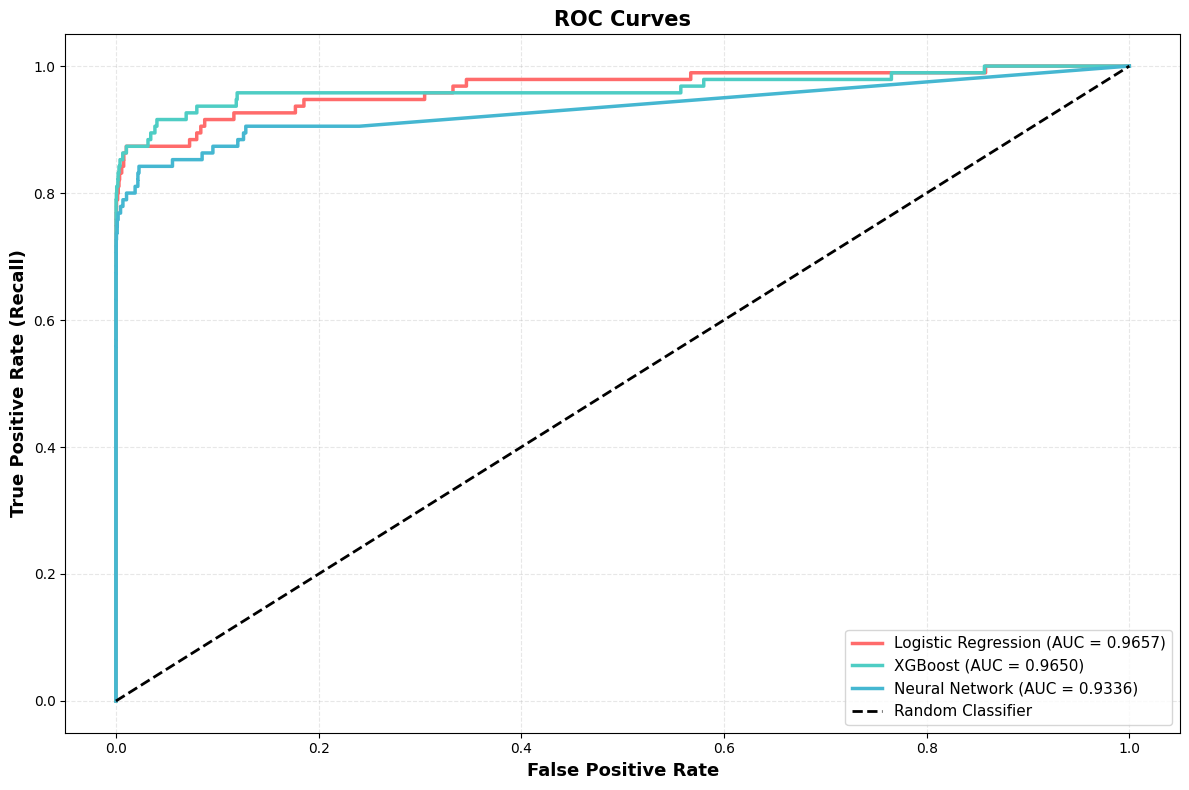

In [30]:
# ROC curves

plt.figure(figsize=(12, 8))

for idx, (model_name, model_data) in enumerate(models.items()):
    fpr, tpr, _ = roc_curve(y_test, model_data['probabilities'])
    roc_auc_val = df_metrics[df_metrics['Model']==model_name]['ROC-AUC'].values[0]

    plt.plot(fpr, tpr, linewidth=2.5, color=colors_pr[idx],
            label=f'{model_name} (AUC = {roc_auc_val:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=13, fontweight='bold')
plt.title('ROC Curves', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

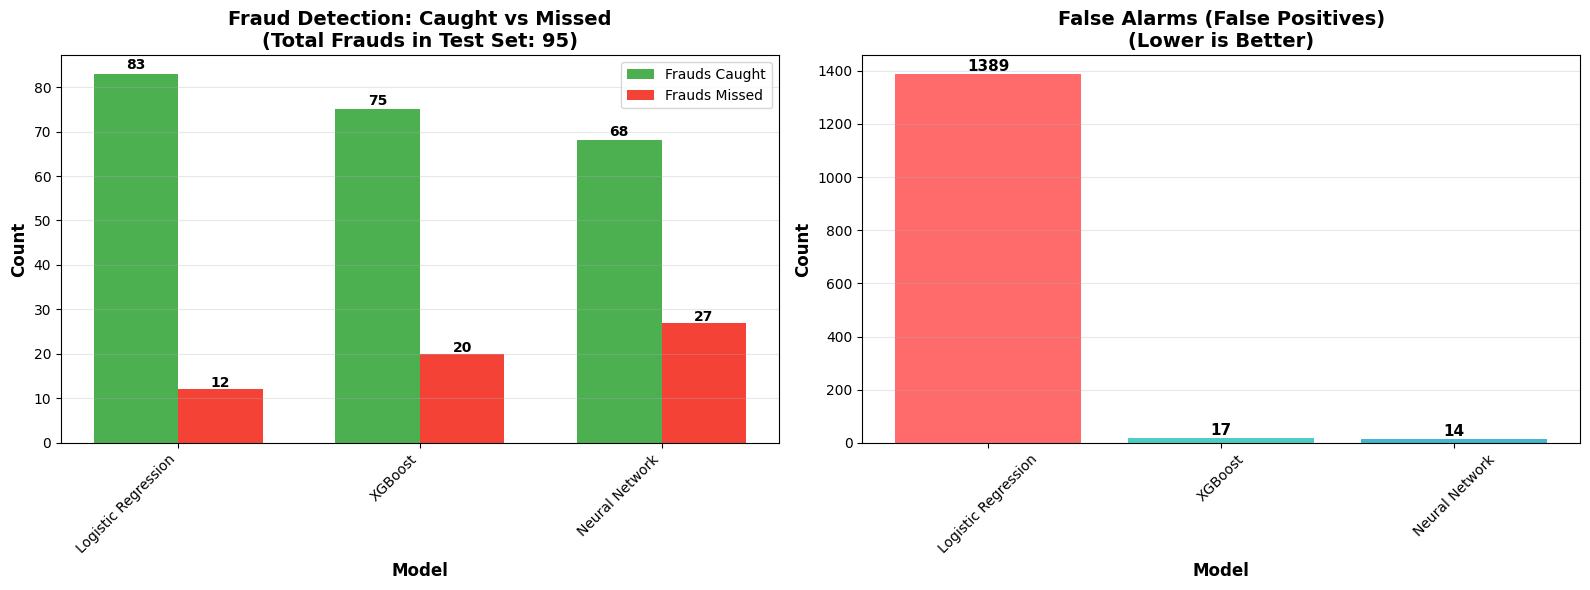

In [31]:
# Fraud detection breakdown

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Frauds Caught vs Missed
frauds_caught = df_metrics['True Positives'].values
frauds_missed = df_metrics['False Negatives'].values
total_frauds = sum(y_test)
x = np.arange(len(df_metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, frauds_caught, width, label='Frauds Caught', color='#4CAF50')
bars2 = axes[0].bar(x + width/2, frauds_missed, width, label='Frauds Missed', color='#F44336')
axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title(f'Fraud Detection: Caught vs Missed\n(Total Frauds in Test Set: {total_frauds})',
                 fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_metrics['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

for i, (caught, missed) in enumerate(zip(frauds_caught, frauds_missed)):
    axes[0].text(i - width/2, caught + 1, str(int(caught)), ha='center', fontweight='bold')
    axes[0].text(i + width/2, missed + 0.5, str(int(missed)), ha='center', fontweight='bold')

# False Alarms
false_alarms = df_metrics['False Positives'].values
bars = axes[1].bar(df_metrics['Model'], false_alarms, color=colors)
axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('False Alarms (False Positives)\n(Lower is Better)',
                 fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('fraud_detection_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()